In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

In [3]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

#### Setup

In [4]:
# Download the image and read it into a NumPy array
def download(url):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = image.load_img(image_path)
    return image.img_to_array(img)

In [5]:
# Scale pixels to between (-1.0 and 1.0)
def preprocess(img):
    return (img / 127.5) - 1

In [11]:
# Undo the preprocessing above
def deprocess(img):
    img = img.copy()
    img /= 2.
    img += 0.5
    img *= 255.
    return np.clip(img, 0, 255).astype('uint8')

In [7]:
# Display an image
def show(img):
    plt.figure(figsize=(12,12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

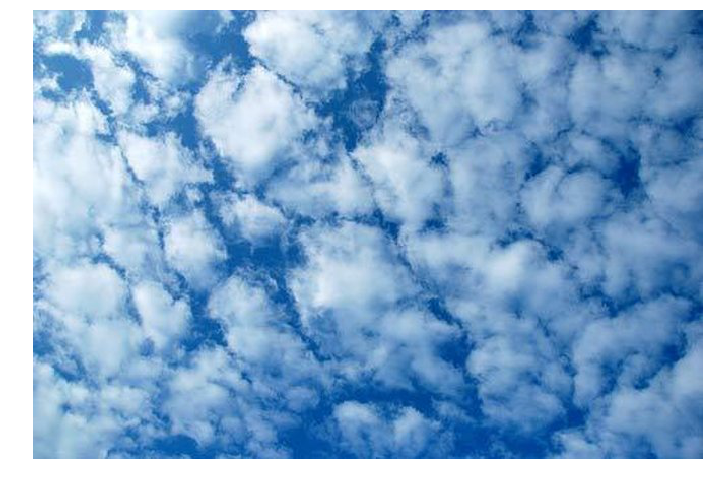

In [14]:
url = 'https://img.purch.com/w/660/aHR0cDovL3d3dy5saXZlc2NpZW5jZS5jb20vaW1hZ2VzL2kvMDAwLzA0MC8xNDcvb3JpZ2luYWwvY2xvdWRzLTAyLmpwZw=='
img = preprocess(download(url))
show(deprocess(img))

#### Build a feature extraction model

In [15]:
# Build a feature extraction mode using Keras Functional API 
# and InceptionV3 pretrained model
# https://github.com/fchollet/deep-learning-models

inception_v3 = tf.keras.applications.InceptionV3(weights='imagenet',
                                                include_top=False)


87916544/87910968 [==============================] - 10s 0us/step


In [17]:
# Maximize activation of these layers:
names = ['mixed2', 'mixed3', 'mixed4', 'mixed5']
layers = [inception_v3.get_layer(name).output for name in names]

# Create feature extraction model
feat_extraction_model = tf.keras.Model(inputs=inception_v3.input, outputs=layers)

Forward pass

In [18]:
def forward(img):
    # Create a batch
    img_batch = tf.expand_dims(img, axis=0)
    
    # Forward the image through Inception, extract activation
    # for the layers we selected above
    return feat_extraction_model(img_batch)

Define the loss function. It'll be the mean activation of each of the layers chosen above.

In [19]:
def calc_loss(layer_activations):
    total_loss = 0
    for act in layer_activations:
        # in gradient ascent, we'll want to maximize this value
        # so out image increasingly 'excites' the layer
        loss = tf.math.reduce_mean(act)
        
        # Normalize by the number of unites in the layer
        loss /= np.prod(act.shape)
        total_loss += loss
        
    return total_loss
        

We can now run gradient ascent. We'll treat our input image as a weight matrix, and find the gradients of the loss with respect to it. Those gradients will have the same shape as the image (since there's one for each pixel) - so we can add them directly to the image to modify it. 

In [ ]:
# Convert the image into a variable for training
img = tf.Variable(img)

# Run a few iterations of gradient ascent 
steps = 200

for step in range(steps):
    with tf.GradientTape() as tape:
        activations = forward(img)
        loss = calc_loss(activations)
        
        #(it's the gradient of the loss (how excited the layer is)
        # with respect to the pixels of a random image)
        gradients = tape.gradient(loss, img)
        
        # Normalize the gradients
        gradients /= gradients.numpy().std() + 1e-8
        
        # Update the image by directly adding the gradients
        # (they are the same shape)
        img.assign_add(gradients)
        
        if step % 50 == 0:
            clear_output()
            print('Step %d, loss %f' % (step, loss))
            show(deprocess(img.numpy()))

initial source in TensorFlow 1:
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.2-deep-dream.ipynb